In [1]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

import joblib
from copy import deepcopy
import seaborn as sns

In [2]:
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [3]:
reduce_model = joblib.load("best/reduce_model.pkl")
c_model = joblib.load("best/c_model.pkl")

In [4]:
main_reduced = reduce_model.transform(dataset)

In [5]:
def clf_per_seed(n=10, metric = ClassifierModel.score):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
        main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
        #stratify=target.values.ravel()
        )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            result[clf][seed] = metric(y_test, clfs.models[clf].predict(X_test))
    
    
    
    return result





    

In [6]:
r = pd.DataFrame(clf_per_seed(50))

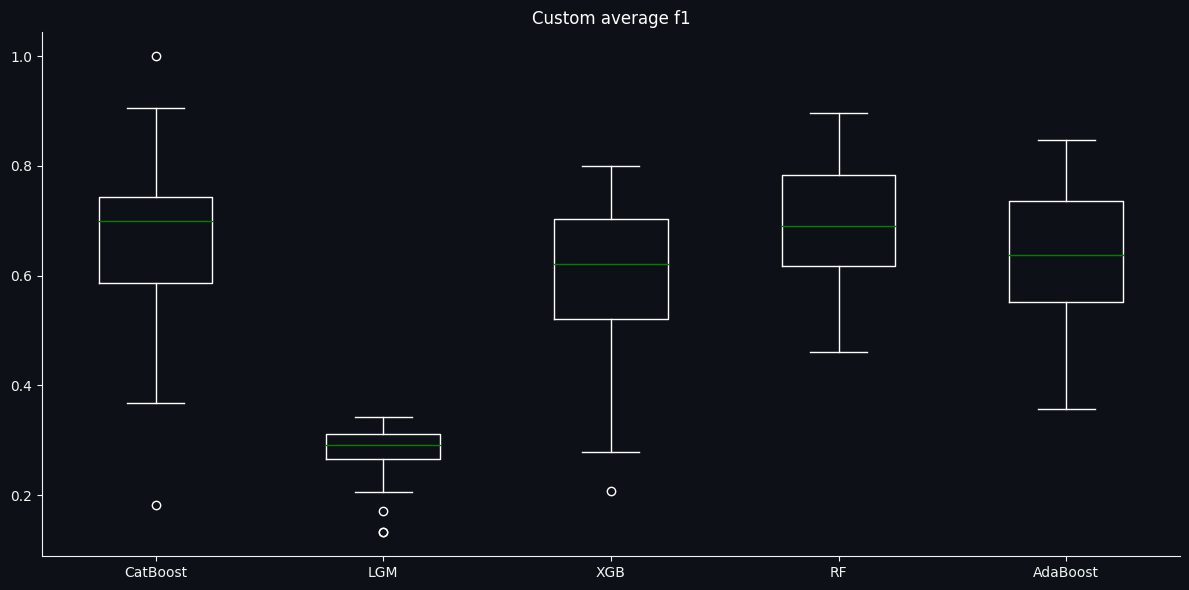

In [7]:
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("Custom average f1")
plt.tight_layout()
plt.show()

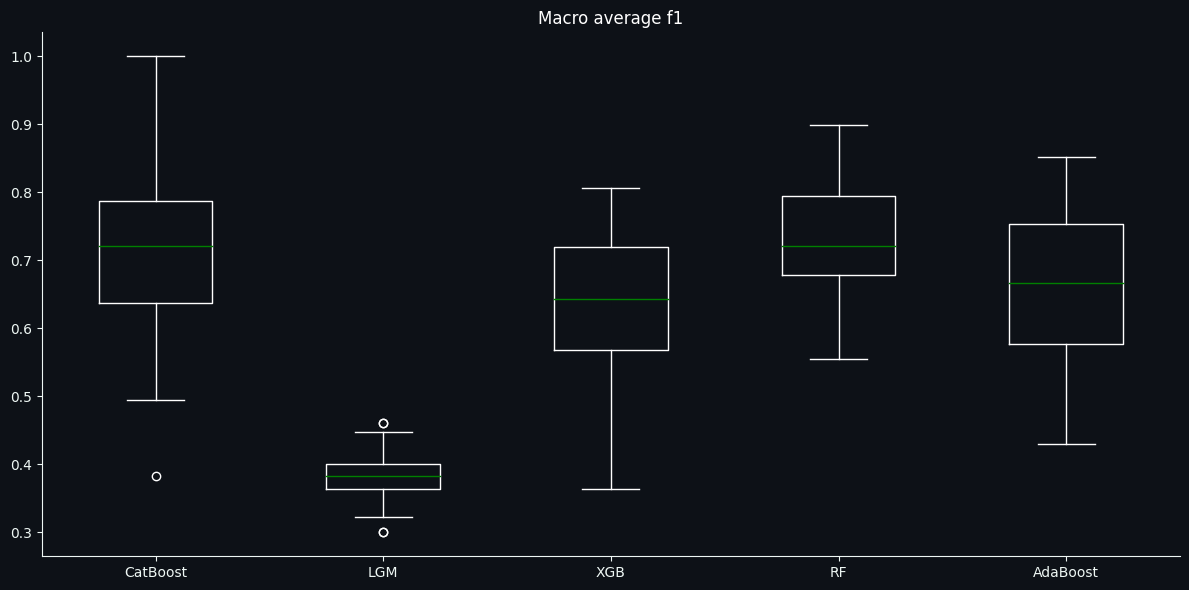

In [8]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, average="macro")))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("Macro average f1")
plt.tight_layout()
plt.show()

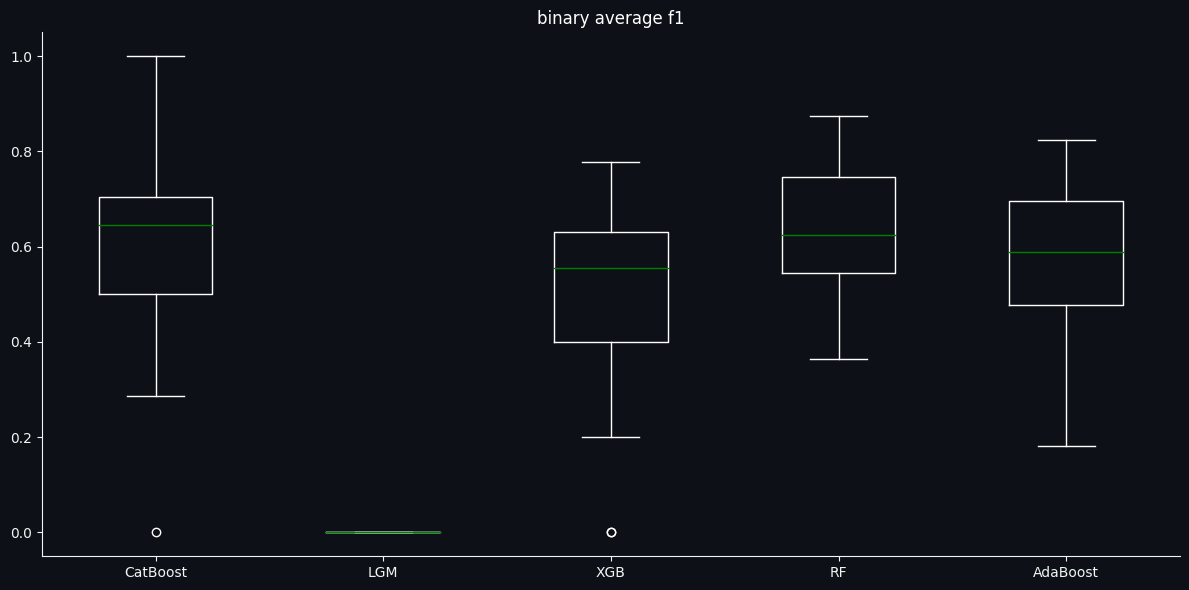

In [9]:
r = pd.DataFrame(clf_per_seed(50, lambda y_t, y_p: metrics.f1_score(y_t, y_p, pos_label=1)))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="w"),
            capprops=dict(color="w"),
            whiskerprops=dict(color="w"),
            medianprops=dict(color="g"),
            flierprops=dict(color="w", markeredgecolor="w"),
            )
plt.title("binary average f1")
plt.tight_layout()
plt.show()

In [79]:
def clf_per_ls_dim(dim):
    reduce_model = ReduceModel(model="AE", layers=(1169, 500, 200, dim))
    reduce_model.train(epochs=60, lr=1e-3)

    main_reduced = reduce_model.transform(dataset)

    X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    c_model = ClassifierModel()
    res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)
    c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
    c_model.fit(X_train, y_train)
    res = {"model": deepcopy(c_model),
                "data": [X_train, X_test, y_train, y_test]}
    for name in c_model.models:
        pred = c_model.models[name].predict(X_test)
        print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
        print(metrics.classification_report(y_test, pred))
    return res

In [80]:
store = {i: clf_per_ls_dim(i) for i in [40, 30, 20, 10, 8, 6, 5, 2]}


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:20<00:00,  2.88it/s]

Epoch 60, Train Loss: 0.0024771682192506485
Epoch 60, Validation Loss: 0.0025923002130267296
evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 59/9223372036854775807 [00:10<435536247580491:56:48,  5.88trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 311/9223372036854775807 [00:10<82577826961880:35:12, 31.03trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 232/9223372036854775807 [00:10<110868673109231:19:28, 23.11trial/s, best loss: -0.5022727272727273]
evaluate RF
  0%|          | 73/9223372036854775807 [00:10<354124655249840:46:56,  7.23trial/s, best loss: -0.5501207729468599]
evaluate AdaBoost
  0%|          | 455/9223372036854775807 [00:10<56371881948278:09:36, 45.45trial/s, best loss: -0.45833333333333337]


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.75
              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78        13
         1.0       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.61
              precision    recall  f1-score   support

         0.0       0.78      0.54      0.64        13
         1.0       0.50      0.75      0.60         8

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weight

100%|██████████| 60/60 [00:20<00:00,  2.87it/s]

Epoch 60, Train Loss: 0.0028525630856842494
Epoch 60, Validation Loss: 0.0029522468843920665
evaluate CatBoost
  0%|          | 1/9223372036854775807 [00:00<352310402490331:35:28,  7.27trial/s, best loss: -0.629156010230179]

  0%|          | 65/9223372036854775807 [00:10<402304613558118:58:08,  6.37trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 321/9223372036854775807 [00:10<80033091732478:51:44, 32.01trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 233/9223372036854775807 [00:10<110378525172665:01:52, 23.21trial/s, best loss: -0.8020833333333331]
evaluate RF
  0%|          | 77/9223372036854775807 [00:10<332734589580820:50:08,  7.70trial/s, best loss: -0.5022727272727273]
evaluate AdaBoost
  0%|          | 475/9223372036854775807 [00:10<54040846045704:29:52, 47.41trial/s, best loss: -0.3363636363636364]


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.82
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        13
         1.0       1.00      0.62      0.77         8

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.39
              precision    recall  f1-score   support

         0.0       0.57      0.62      0.59        13
         1.0       0.29      0.25      0.27         8

    accuracy                           0.48        21
   macro avg       0.43      0.43      0.43        21
weight

100%|██████████| 60/60 [00:18<00:00,  3.23it/s]

Epoch 60, Train Loss: 0.0036078544366065154
Epoch 60, Validation Loss: 0.0036981472830203447
evaluate CatBoost
  0%|          | 1/9223372036854775807 [00:00<383759489243691:14:08,  6.68trial/s, best loss: -0.6823529411764705]

  0%|          | 62/9223372036854775807 [00:10<416659754005130:01:36,  6.15trial/s, best loss: -0.6130952380952381]
evaluate LGM
  0%|          | 325/9223372036854775807 [00:09<78765144988351:19:28, 32.53trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 242/9223372036854775807 [00:10<106079995877715:10:56, 24.15trial/s, best loss: -0.5022727272727273]
evaluate RF
  0%|          | 83/9223372036854775807 [00:10<311071202383323:35:28,  8.24trial/s, best loss: -0.6041666666666666]
evaluate AdaBoost
  0%|          | 59/9223372036854775807 [00:10<434855109444979:50:24,  5.89trial/s, best loss: -0.5625]            


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.77
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        13
         1.0       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.57
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69        13
         1.0       0.50      0.50      0.50         8

    accuracy                           0.62        21
   macro avg       0.60      0.60      0.60        21
weight

100%|██████████| 60/60 [00:18<00:00,  3.23it/s]

Epoch 60, Train Loss: 0.0034412420787956824
Epoch 60, Validation Loss: 0.0036192720078609204
evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 86/9223372036854775807 [00:10<302066705765200:51:12,  8.48trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 340/9223372036854775807 [00:10<75580308921951:13:04, 33.90trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 277/9223372036854775807 [00:10<92769163372516:06:24, 27.62trial/s, best loss: -0.7300724637681159] 
evaluate RF
  0%|          | 78/9223372036854775807 [00:10<330334908402642:37:52,  7.76trial/s, best loss: -0.45833333333333337]
evaluate AdaBoost
  0%|          | 65/9223372036854775807 [00:10<399238818033538:50:40,  6.42trial/s, best loss: -0.7300724637681159]


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.82
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90        13
         1.0       1.00      0.62      0.77         8

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.70
              precision    recall  f1-score   support

         0.0       0.75      0.92      0.83        13
         1.0       0.80      0.50      0.62         8

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weight

100%|██████████| 60/60 [00:18<00:00,  3.22it/s]

Epoch 60, Train Loss: 0.00375252774223512
Epoch 60, Validation Loss: 0.0038936626039106736
evaluate CatBoost
  0%|          | 2/9223372036854775807 [00:00<202483007172262:09:04, 12.65trial/s, best loss: -0.7419607843137256]

  0%|          | 108/9223372036854775807 [00:10<239765630918538:42:08, 10.69trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 334/9223372036854775807 [00:10<76837354701580:30:24, 33.34trial/s, best loss: -0.25462962962962965] 
evaluate XGB
  0%|          | 275/9223372036854775807 [00:09<93095416294054:42:08, 27.52trial/s, best loss: -0.6041666666666666] 
evaluate RF
  0%|          | 81/9223372036854775807 [00:10<316405541094793:42:24,  8.10trial/s, best loss: -0.6041666666666666]
evaluate AdaBoost
  0%|          | 61/9223372036854775807 [00:10<427580785526648:19:12,  5.99trial/s, best loss: -0.7300724637681159]
report for CatBoost: 0.83
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89        13
         1.0       0.86      0.75      0.80         8

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21

report 

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

Epoch 60, Train Loss: 0.0026130790627279946
Epoch 60, Validation Loss: 0.002786754969168793
evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 84/9223372036854775807 [00:10<305846335499127:13:04,  8.38trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 287/9223372036854775807 [00:10<89399941073181:12:32, 28.66trial/s, best loss: -0.25462962962962965] 
evaluate XGB
  0%|          | 266/9223372036854775807 [00:10<96564193062800:59:44, 26.53trial/s, best loss: -0.6130952380952381] 
evaluate RF
  0%|          | 66/9223372036854775807 [00:10<390697324318622:21:52,  6.56trial/s, best loss: -0.6041666666666666]
evaluate AdaBoost
  0%|          | 57/9223372036854775807 [00:10<455997242441260:26:40,  5.62trial/s, best loss: -0.6533400809716601]


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.68
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        13
         1.0       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71      0.71      0.71        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.74
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87        13
         1.0       1.00      0.50      0.67         8

    accuracy                           0.81        21
   macro avg       0.88      0.75      0.77        21
weight

100%|██████████| 60/60 [00:22<00:00,  2.73it/s]

Epoch 60, Train Loss: 0.004838732840103465
Epoch 60, Validation Loss: 0.005025110842490738
evaluate CatBoost
  0%|          | 1/9223372036854775807 [00:00<343515531147710:00:32,  7.46trial/s, best loss: -0.6221719457013575]

  0%|          | 76/9223372036854775807 [00:10<338632590363917:56:16,  7.57trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 249/9223372036854775807 [00:10<103186821034479:09:52, 24.83trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 201/9223372036854775807 [00:10<128056691290619:17:20, 20.01trial/s, best loss: -0.7300724637681159]
evaluate RF
  0%|          | 48/9223372036854775807 [00:10<536354714197251:24:48,  4.78trial/s, best loss: -0.6130952380952381]
evaluate AdaBoost
  0%|          | 53/9223372036854775807 [00:09<483382273140458:18:40,  5.30trial/s, best loss: -0.7300724637681159]


C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

report for CatBoost: 0.61
              precision    recall  f1-score   support

         0.0       0.71      0.92      0.80        13
         1.0       0.75      0.38      0.50         8

    accuracy                           0.71        21
   macro avg       0.73      0.65      0.65        21
weighted avg       0.72      0.71      0.69        21

report for LGM: 0.29
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB: 0.57
              precision    recall  f1-score   support

         0.0       0.69      0.85      0.76        13
         1.0       0.60      0.38      0.46         8

    accuracy                           0.67        21
   macro avg       0.64      0.61      0.61        21
weight

100%|██████████| 60/60 [00:21<00:00,  2.78it/s]

Epoch 60, Train Loss: 0.006731747281412745
Epoch 60, Validation Loss: 0.006862382023510608
evaluate CatBoost
  0%|          | 1/9223372036854775807 [00:00<313922786525912:10:40,  8.16trial/s, best loss: -0.6823529411764705]

  0%|          | 75/9223372036854775807 [00:10<347052643765204:16:00,  7.38trial/s, best loss: -0.7300724637681159]
evaluate LGM
  0%|          | 263/9223372036854775807 [00:10<97872495674569:26:24, 26.18trial/s, best loss: -0.25462962962962965] 
evaluate XGB
  0%|          | 273/9223372036854775807 [00:10<93895079950007:56:48, 27.29trial/s, best loss: -0.8541666666666666] 
evaluate RF
  0%|          | 66/9223372036854775807 [00:10<391586438658231:28:00,  6.54trial/s, best loss: -0.6681818181818182]
evaluate AdaBoost
  0%|          | 44/9223372036854775807 [00:10<586658478315128:32:00,  4.37trial/s, best loss: -0.6681818181818182]
report for CatBoost: 0.65
              precision    recall  f1-score   support

         0.0       0.73      0.85      0.79        13
         1.0       0.67      0.50      0.57         8

    accuracy                           0.71        21
   macro avg       0.70      0.67      0.68        21
weighted avg       0.71      0.71      0.70        21

report f

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

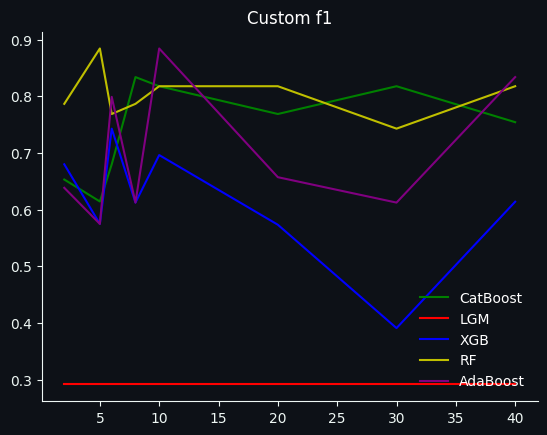

In [87]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [ClassifierModel.score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1])) for dim in store.keys()], label=name)

plt.legend()
plt.title("Custom f1")
plt.show()


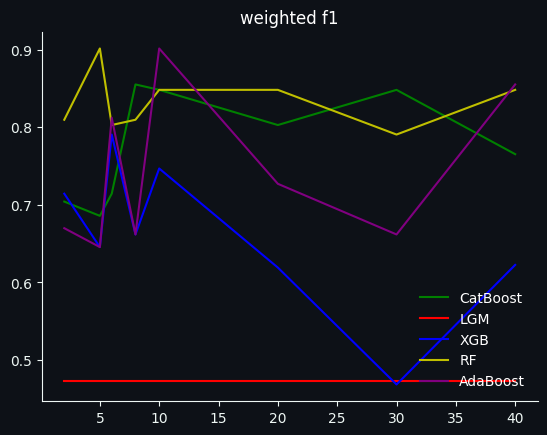

In [91]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [metrics.f1_score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1]), average="weighted") for dim in store.keys()], label=name)

plt.legend()
plt.title("weighted f1")
plt.show()